In [7]:
library(caret)
library(dplyr)

mvpRanks = read.csv('All_player_data.csv')
allgames = read.csv('every_game.csv')

teamWins = allgames %>% 
  select(game_result, team_id, year_id,is_playoffs) %>%
  filter(year_id >= 1989, is_playoffs == 0) %>%
  group_by(team_id, year_id) %>%
  mutate(Wins = sum(game_result == 'W')) %>%
  distinct(team_id, year_id, Wins) 

mvpRanks = left_join(mvpRanks, teamWins, c("Tm_x" = "team_id", "season_end" = "year_id"))

topPlayers = mvpRanks %>%
  filter((PS.G >= 20 & OBPM >= 0 & DBPM >= 0) | MVP == 1,  season_end < 2012) %>%
  group_by(season_end) %>%
  top_n(5) %>%
  select(player, MVP, GS, PS.G, TRB, AST, STL, BLK, TOV, OBPM, DBPM,Wins) 

mvp_glm <- glm(MVP ~ GS + PS.G + TRB + AST + STL + BLK + TOV + OBPM + DBPM, data = topPlayers, family = binomial)

topPlayersTest = mvpRanks %>%
  filter((PS.G >= 20 & OBPM >= 0 & DBPM >= 0) | MVP == 1,  season_end > 2012) %>%
  group_by(season_end) %>%
  top_n(5) %>%
  select(player, MVP, GS, PS.G, TRB, AST, STL, BLK, TOV, OBPM, DBPM,Wins) 

# logistic regression
mvp_glm.test = predict(mvp_glm, topPlayersTest[, c('GS', 'PS.G', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'OBPM', 'DBPM','Wins')], type="response")

topPlayersTest
mvp_glm.test




Warning message:
“Column `Tm_x`/`team_id` joining factors with different levels, coercing to character vector”Selecting by Wins
Adding missing grouping variables: `season_end`
Selecting by Wins
Adding missing grouping variables: `season_end`


season_end,player,MVP,GS,PS.G,TRB,AST,STL,BLK,TOV,OBPM,DBPM,Wins
2013,Kevin Durant,0,81,28.1,7.9,4.6,1.4,1.3,3.5,6.2,1.4,60
2013,James Harden,0,78,25.9,4.9,5.8,1.8,0.5,3.8,5.4,0.1,45
2013,LeBron James,1,76,26.8,8.0,7.3,1.7,0.9,3.0,9.2,2.4,66
2013,Dwyane Wade,0,69,21.2,5.0,5.1,1.9,0.8,2.8,2.8,1.1,66
2013,Russell Westbrook,0,82,23.2,5.2,7.4,1.8,0.3,3.3,4.7,0.3,60
2014,Kevin Durant,1,81,32.0,7.4,5.5,1.3,0.7,3.5,8.4,0.4,59
2014,Paul George,0,80,21.7,6.8,3.5,1.9,0.3,2.8,2.9,1.8,56
2014,Blake Griffin,0,80,24.1,9.5,3.9,1.2,0.6,2.8,3.0,1.6,57
2014,LeBron James,0,77,27.1,6.9,6.3,1.6,0.3,3.5,8.0,0.9,54
2014,Russell Westbrook,0,46,21.8,5.7,6.9,1.9,0.2,3.8,5.2,1.2,59


1          2          3          4          5          6          7 
0.28286663 0.10779155 0.57099484 0.01634789 0.22633076 0.73712285 0.01923747 
         8          9         10         11         12         13         14 
0.16968714 0.35030815 0.01371463 0.04756255 0.17087032 0.16018679 0.34059124 
        15         16 
0.25087569 0.14168014

In [8]:
library(randomForest)
mvp_ranForest <- randomForest(MVP ~ GS + PS.G + TRB + AST + STL + BLK + TOV + OBPM + DBPM + Wins, data = topPlayers)
print(mvp_ranForest)
print(importance(mvp_ranForest,type = 2)) 

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”


Call:
 randomForest(formula = MVP ~ GS + PS.G + TRB + AST + STL + BLK +      TOV + OBPM + DBPM + Wins, data = topPlayers) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 3

          Mean of squared residuals: 0.1177756
                    % Var explained: 23.98
     IncNodePurity
GS       0.6652881
PS.G     2.0781836
TRB      1.8644605
AST      1.9536443
STL      0.8168356
BLK      0.8101848
TOV      0.9954438
OBPM     2.1494052
DBPM     1.6892638
Wins     3.6635236


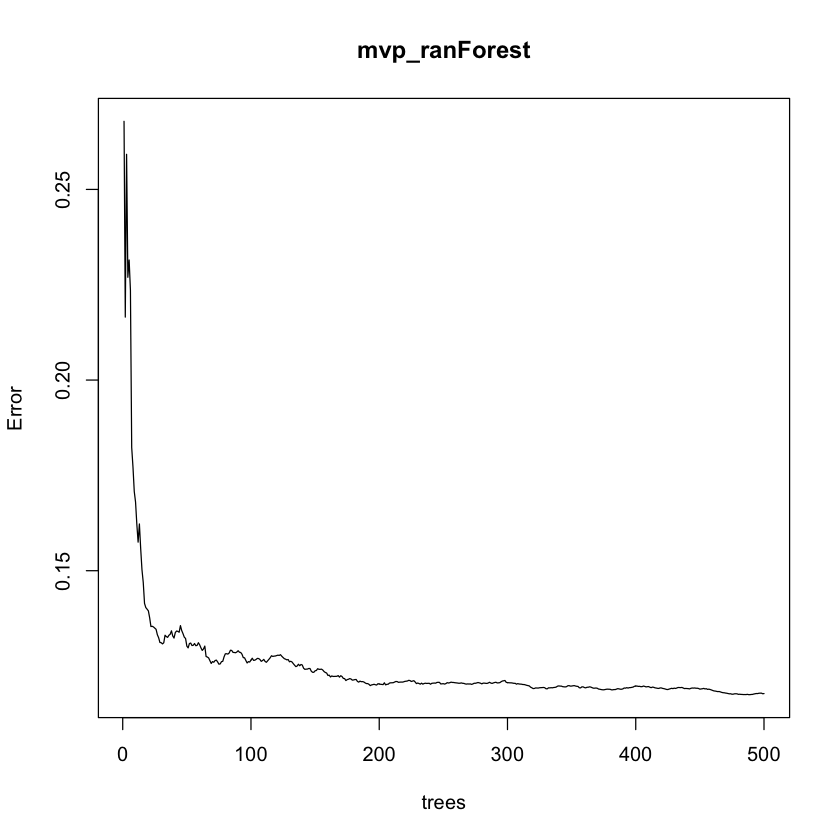

In [9]:
plot(mvp_ranForest)

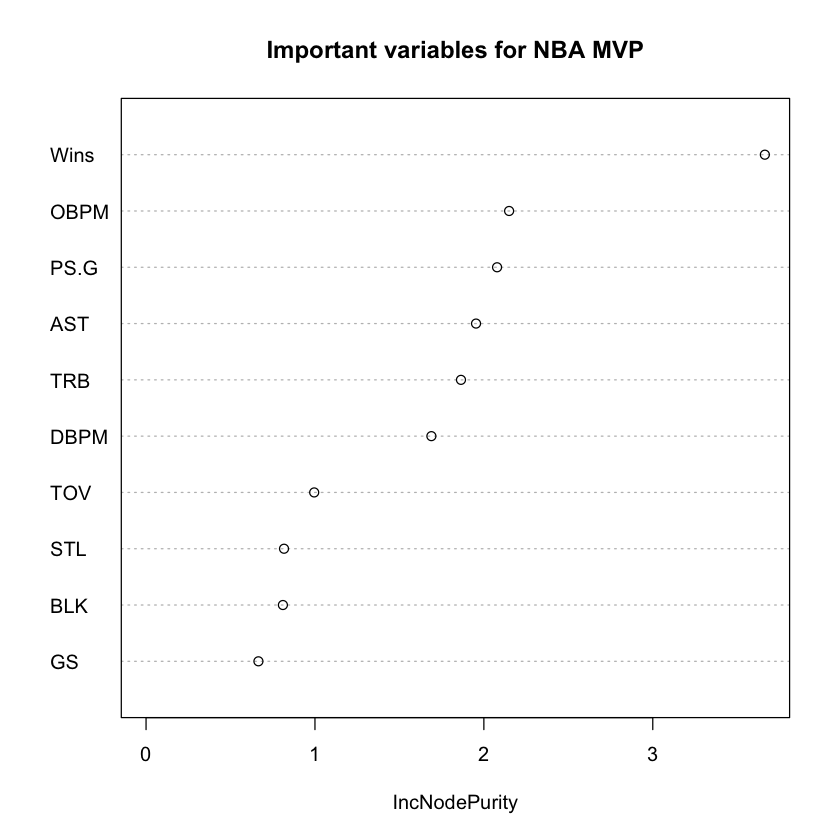

In [10]:
varImpPlot(mvp_ranForest,main="Important variables for NBA MVP")